In [36]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow import keras
import sys
import PIL
import os
import tensorflow.keras.backend as K
import glob
sys.path.append('../scripts/helper_functions_cv/tensorflow_helpers/')
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
import segmentation_models as sm
sm.set_framework('tf.keras')
import multiprocessing as mp
from save_weights_every_epoch import CallbackForSavingModelWeights
from change_learning_rate_epoch import ChangeLR
import multiprocessing as mp
import dask.array as da
import cv2
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
import dask

In [7]:
csv_file = pd.read_csv('../../files/train_ship_segmentations_v2.csv')
csv_file = csv_file.groupby('ImageId')['EncodedPixels'].apply(list).reset_index()
image_ids, pixels = csv_file['ImageId'].values.tolist(), csv_file['EncodedPixels'].values.tolist()

In [8]:
csv_file['fixed_inputs'] = csv_file['ImageId'].apply(lambda x: '../../files/train_v2/' + x)
csv_file['mask_paths'] = csv_file['ImageId'].apply(lambda x: '../../files/masks_v1/train/' + x.split('.')[0] + '.' + 'png')

In [9]:
for x in tqdm(csv_file['fixed_inputs'].values.tolist()):
    if os.path.exists(x) == False:
        print(x)

100%|██████████| 192556/192556 [00:01<00:00, 180359.56it/s]


In [10]:
for x in tqdm(csv_file['mask_paths'].values.tolist()):
    if os.path.exists(x) == False:
        print(x)

100%|██████████| 192556/192556 [00:01<00:00, 183694.46it/s]


In [11]:
csv_file = csv_file[csv_file['fixed_inputs'] != '../../files/train_v2/6384c3e78.jpg']

In [12]:
gpus = tf.config.list_physical_devices("GPU")

In [13]:
allowed_gpus = [0]
gpus = tf.config.list_physical_devices("GPU")
final_gpu_list = [gpus[x] for x in allowed_gpus]
tf.config.set_visible_devices(final_gpu_list, "GPU")
for gpu in final_gpu_list:
    tf.config.experimental.set_memory_growth(gpu, True)

strategy = tf.distribute.MirroredStrategy()
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [14]:
load_dotenv('../config_files/dev.env')

True

In [15]:
def split_datasets(csv_file, test_size = 0.01):
    train, test = train_test_split(csv_file, test_size = test_size, random_state=42)
    train, val = train_test_split(train, test_size = test_size, random_state=42)
    return train, val, test

In [16]:
# csv_file = pd.read_csv
train, val, test = split_datasets(csv_file)

In [17]:
type_of_label = []
for x in train['EncodedPixels'].values.tolist():
    if type(x[0]) == str:
        type_of_label.append(1)
    else:
        type_of_label.append(0)

In [18]:
os.environ['tb_path']

'/home/ubuntu/ship_segmentation/TB/'

In [19]:
def only_imgs(img, shape):
    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size=shape)
    img = img / 255
    return img

def only_imgs_masks(img, mask, shape):
    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size=shape)
    mask = tf.io.read_file(mask)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, size=shape)
    img = img / 255
    mask = mask / 255
    return img, mask

def get_data(data, shape = (256, 256), shuffle = True, repeat = True, batch = True, batch_size = 32):
    imgs, masks = data['fixed_inputs'].values.tolist(), data['mask_paths'].values.tolist()
    shapes = [shape for x in range(len(imgs))]
    tensor = tf.data.Dataset.from_tensor_slices((imgs, masks, shapes))
    tensor = tensor.cache()
    if repeat:
        tensor = tensor.repeat()
    if shuffle:
        tensor = tensor.shuffle(256 * REPLICAS)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        tensor = tensor.with_options(opt)
    tensor = tensor.map(only_imgs_masks)
    if batch:
        tensor = tensor.batch(batch_size * REPLICAS)
    tensor = tensor.prefetch(AUTO)
    return tensor

def get_data_test(data, shape = (256, 256), shuffle = True, repeat = True, batch = True, batch_size = 32):
    imgs = data
    shapes = [shape for x in range(len(imgs))]
    tensor = tf.data.Dataset.from_tensor_slices((imgs, shapes))
    tensor = tensor.cache()
    if repeat:
        tensor = tensor.repeat()
    if shuffle:
        tensor = tensor.shuffle(256 * REPLICAS)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        tensor = tensor.with_options(opt)
    tensor = tensor.map(only_imgs)
    if batch:
        tensor = tensor.batch(batch_size * REPLICAS)
    tensor = tensor.prefetch(AUTO)
    return tensor

In [20]:
# train_dataset = get_data(train, shape=(512, 512), shuffle=False, repeat=False, batch_size=32)
# val_dataset = get_data(val, shape=(512, 512), shuffle=False, repeat=False, batch_size=32)
# test_dataset = get_data(test, shape=(512, 512), shuffle=False, repeat=False, batch_size=32)

In [21]:
def get_model(model_name):
    with strategy.scope():
        model = sm.Unet(model_name)
        model.compile(
            tf.keras.optimizers.SGD(momentum=0.8),
            loss = sm.losses.bce_dice_loss,
            metrics = [sm.metrics.iou_score]
        )
    return model

In [22]:
with strategy.scope():
    model = get_model('inceptionv3')
    model.load_weights('../../best_weight/100.h5')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [23]:
# model.evaluate(train_dataset, verbose=1)

In [24]:
# model.evaluate(val_dataset, verbose=1)

In [25]:
# model.evaluate(test_dataset, verbose=1)

In [26]:
# train_dataset = get_data_test(train['fixed_inputs'].values.tolist(), shape=(512, 512), shuffle=False, repeat=False, batch_size=32)
# val_dataset = get_data(val, shape=(512, 512), shuffle=False, repeat=False, batch_size=32)
# test_dataset = get_data(test, shape=(512, 512), shuffle=False, repeat=False, batch_size=32)

In [27]:
train_paths = train['fixed_inputs'].values
train_masks = train['mask_paths'].values
train_paths_splits = np.split(train_paths, np.arange(5000, len(train_paths), 5000))
train_masks_splits = np.split(train_masks, np.arange(5000, len(train_paths), 5000))

In [52]:
def g_mask_read(img_path):
    im = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    im = cv2.resize(im, (512, 512), cv2.INTER_LINEAR)
    im = im / 255
    im = np.where(im < 1, 0, 1)
    return im 

In [51]:
# def generate_numpy_files(data):
#     try:
#         paths, masks, count = data[0], data[1], data[2]
#         K.clear_session()
#         dataset = get_data_test(paths, shape=(512, 512), shuffle=False, repeat=False, batch_size=32)
#         preds = model.predict(dataset, verbose = 1)
#         with mp.Pool(15) as p:
#             g_truths = np.array(p.map(g_mask_read, masks)).flatten()
#         preds = preds.flatten()
#         np.save(f'../../np_arrays/g_truths/{count}.npy', g_truths)
#         np.save(f'../../np_arrays/preds/{count}.npy', preds)
#         return 'DONE'
#     except:
#         return count

In [53]:
count = 0
g_t, p_p = None, None
for idx in range(len(train_paths_splits)):
    K.clear_session()
    dataset = get_data_test(train_paths_splits[idx], shape=(512, 512), shuffle=False, repeat=False, batch_size=32)
    preds = model.predict(dataset, verbose = 1)
    with mp.Pool(15) as p:
        g_truths = np.array(p.map(g_mask_read, train_masks_splits[idx])).flatten()
    preds = preds.flatten()
    g_t, p_p = g_truths, preds
    np.save(f'../../np_arrays/g_truths/{count}.npy', g_truths)
    np.save(f'../../np_arrays/preds/{count}.npy', preds)
    count += 1

117/117 [==============================] - 24s 200ms/step


In [47]:
np.unique(g_t)

array([0, 1])

In [48]:
p_p

array([1.7145459e-04, 3.2782152e-06, 7.7346285e-06, ..., 2.8677005e-06,
       6.9047573e-08, 3.1193013e-06], dtype=float32)

In [2]:
import pickle

In [31]:
def process_large_files(data):
    g_p, p_p, thres = data[0], data[1], data[2]
    g_truth = np.load(g_p)
    pred = np.load(p_p)
    gt_da = dask.array.from_array(g_truth)
    p_da = dask.array.from_array(pred)
    p_da = da.where(p_da > thres, 1, 0)
    TP = da.sum(da.logical_and(gt_da == 1, p_da == 1))
    TN = da.sum(da.logical_and(gt_da == 0, p_da == 0))
    FP = da.sum(da.logical_and(gt_da == 0, p_da == 1))
    FN = da.sum(da.logical_and(gt_da == 1, p_da == 0))
    TP, TN, FP, FN = TP.compute(), TN.compute(), FP.compute(), FN.compute()
    return [TP, TN, FP, FN]

In [33]:
thres_preds = []
count = 0
results = None
thres = np.linspace(0,1,num=100)
for x in range(len(thres)):
    g_truth_paths, pred_paths = [f'../../np_arrays/g_truths/{x}.npy' for x in range(38)], [f'../../np_arrays/preds/{x}.npy' for x in range(38)]
    thres_list = [thres[x] for y in range(len(g_truth_paths))]
    data_preps = list(zip(g_truth_paths, pred_paths, thres_list))
    with mp.Pool(6) as p:
        results = np.array(p.map(process_large_files, data_preps))
    TP, TN, FP, FN = np.sum(results[:, 0]), np.sum(results[:, 1]), np.sum(results[:, 2]), np.sum(results[:, 3])
    thres_preds.append((thres[x], TP, TN, FP, FN))
    with open('../../confusion_mat.pickle', 'wb') as handle:
        pickle.dump(thres_preds, handle)

In [34]:
with open('../../confusion_mat.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [39]:
data_array = np.array(data)

In [41]:
thres = data_array[:, 0]

In [42]:
# tpr_rate = tp / (tp + fn)
# fpr_rate = fp / (fp + tn)

In [43]:
tp, tn, fp, fn = data_array[:, 1], data_array[:, 2], data_array[:, 3], data_array[:, 4]

In [44]:
fprs = []
tprs = []
for x in range(len(tp)):
    fpr = fp[x] / (fp[x] + tn[x])
    tpr = tp[x] / (tp[x] + fn[x])
    fprs.append(fpr)
    tprs.append(tpr)

In [54]:
thres = data_array[:, 0]
fprs = np.array(fprs)
tprs = np.array(tprs)

Best Threshold=0.010101, G-Mean=0.984


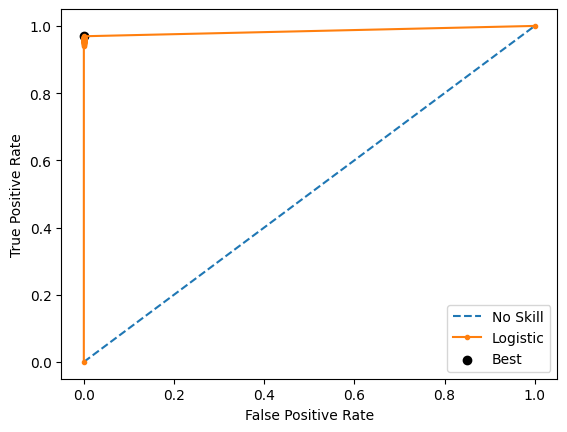

In [63]:
# fpr, tpr, thresholds = roc_curve(testy, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tprs * (1-fprs))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thres[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fprs, tprs, marker='.', label='Logistic')
pyplot.scatter(fprs[ix], tprs[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [64]:
from sklearn import metrics

In [65]:
metrics.auc(fprs, tprs)

0.9845929122663014